# Baumhofer Data - First 100 Cycles Only, With Time Series Interpolation
For the Baumhofer data, we consider only the first 100 cycles for each cell. The objective is to use as input <b>one cycle of data</b> and predict the following targets:

- number of cycles until knee onset
- number of cycles until knee point
- number of cycles until end of life (EOL)
- the capacity degradation that will occur between the capacity at input cycle and the capacity at knee onset
- the capacity degradation that will occur between the capacity at input cycle and the capacity at knee point

The focus is on <u>early prediction</u>, meaning we train using data taken from the first 100 cycles, and we predict within the first 100 cycles also.<br>

An additional time series array (Q) is constructed by integrating the current over time. Rather than using the arrays of voltage and elapsed time as inputs (as was done with Weihan Li's LSTM paper), the time series arrays are resampled to be regularly spaced in time.<br>

This notebook is kept separate to the notebook that considers the "full" data (all cycles per cell), because there are a lot of cleaning steps that are necessary for the full data, but not for the first 100 cycles. This prevents wasted processing time. As such, some of the functions defined in "baumhofer_utils.py" are not utilised in this notebook.

In [3]:
import sys
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.signal import medfilt
import tensorflow as tf

from baumhofer_utils import *
from knee_finder import KneeFinder

In [4]:
# Set up some constants
# The time interval, in seconds, between the interpolated measurements
TIME_FREQ = 5
# Keep only the first N cycles for every cell. Do it here to avoid wasted processing.
first_n_cycles = 100

In [5]:
# Load the params_dict from the knee_finder directory
with open("./data/params_dict.pkl", 'rb') as a_file:
    params_dict = pickle.load(a_file)

### Load the saved dictionary containing the first 100 cycles

In [6]:
with open("./data/baumhofer_first_100_cycles.pkl", "rb") as a_file:
    data = pickle.load(a_file)
    
del a_file

### Interpolate the time series data so the samples are regularly spaced in time
This is basically the code from Paula's "utils.py" module, used for Severson pre-processing.<br>
However, it operates on a single array, rather than a full dictionary.<br>

This is done intentionally, to decouple the function from the dictionary's structure and/or nomenclature.<br>
A dictionary containing interpolated arrays can be built using repeated calls to this function.

In [7]:
def interpolate_array(arr, time_arr, integrate=False, time_freq=1):
    '''
    
    
    Parameters
    ----------
    arr (type: numpy.ndarray)
        An array of measured values corresponding to the measurement times in time_arr.
        
    time_arr (type: numpy.ndarray)
        An array of time values at which the measurements in arr were recorded.
        
    integrate (type: bool)
        If True, compute the integral of arr over time_arr using scipy.integrate.cumtrapz().
        This should be used if you want to obtain charge values via Coulomb counting, with
        the input arr being an array of current values.
        
    time_freq (type: int or float)
        The time interval to use between samples in the interpolated array.
        
        
    Returns
    -------
    
    regular_time (type: numpy.ndarray)
        Array of regularly spaced time values
    
    interp_arr (type: numpy.ndarray)
        Array of interpolated values
        
        
    '''
    
    
    if integrate:
        # Create an array of values integrated over time values in time_arr.
        # Insert a zero value at the first index
        arr = np.insert(cumtrapz(arr, time_arr), 0, 0)
        
    # Create an array of regularly spaced times
    regular_time = np.arange(0, np.max(time_arr), time_freq)
    
    # Use interp1d to return a function that approximates y = f(x)
    interp_func = interp1d(time_arr, arr)
    # Use the function to compute array values at the points in regular_time array
    interp_arr = interp_func(regular_time)
    
    return regular_time, interp_arr


In [8]:
# Create a new sub-dictionary inside the data dictionary, to store interpolated data

for cell in data:
    data[cell]['interp_data'] = {cycle: {'V': None, 'I': None, 'T': None, 'Q': None, 't_regular': None} for cycle in data[cell]['ts_data']}
    
# Initialise a variable to find out the length of the longest interpolated array
max_len = 0

# Call the interpolation function for every cycle
for cell in tqdm(data):
    for cycle in data[cell]['interp_data']:
        # Get the elapsed time array
        time_arr = data[cell]['ts_data'][cycle]['t_elapsed']

        # Get the measurement arrays
        V_arr = data[cell]['ts_data'][cycle]['V']
        I_arr = data[cell]['ts_data'][cycle]['I']
        T_arr = data[cell]['ts_data'][cycle]['T']
        
        # Compute interpolated arrays and assign to dictionary
        data[cell]['interp_data'][cycle]['t_regular'], data[cell]['interp_data'][cycle]['V'] = interpolate_array(arr=V_arr, time_arr=time_arr, integrate=False, time_freq=TIME_FREQ)
        _, data[cell]['interp_data'][cycle]['I'] = interpolate_array(arr=I_arr, time_arr=time_arr, integrate=False, time_freq=TIME_FREQ)
        _, data[cell]['interp_data'][cycle]['T'] = interpolate_array(arr=T_arr, time_arr=time_arr, integrate=False, time_freq=TIME_FREQ)
        _, data[cell]['interp_data'][cycle]['Q'] = interpolate_array(arr=I_arr, time_arr=time_arr, integrate=True, time_freq=TIME_FREQ)
        
        if len(data[cell]['interp_data'][cycle]['I']) > max_len:
            max_len = len(data[cell]['interp_data'][cycle]['I'])
            
            
# Delete the unnecessary variables to keep the explorer clean
del cell, cycle, time_arr, V_arr, I_arr, T_arr

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 31.89it/s]


### Do we need to pad the data?
Find the number of unique array lengths that occur in the dataset of interpolated time series arrays.<br>
If there is only one unique array length, then we have no requirement to pad the data to max_len

In [9]:
# Find out how many unique array lengths there are in the interpolated data
unique_arr_lengths = set()

for cell in data:
    for cycle in data[cell]['interp_data']:
        arr_len = len(data[cell]['interp_data'][cycle]['V'])
        unique_arr_lengths.add(arr_len)
        
del cell, cycle, arr_len

### Pad the time series arrays to the max length

In [10]:
if len(unique_arr_lengths) > 1:
    # Specify a mask value to be used for padding.
    # Use NAN so normalisation is not affected.
    mask_val = np.nan

    # Create a sub-dictionary in data dictionary to store the interpolated arrays that have been nan-padded
    for cell in data:
        data[cell]['padded_data'] = {cycle: {'V': None, 'I': None, 'T': None, 'Q': None} for cycle in data[cell]['interp_data']}

    # Loop through the time series arrays and extend them with np.nan, to have length of max_len
    for cell in tqdm(data):
        for cycle in data[cell]['interp_data']:
            # For each variable e.g. voltage, time
            for var in data[cell]['interp_data'][cycle]:
                # Store the data in a variable for readability
                arr = data[cell]['interp_data'][cycle][var]
                # Find the current length of the array
                current_len = arr.shape[0]
                # Specify how many padded values to add
                num_pad_vals_to_add = max_len - current_len

                # Generate the padded array
                padded_arr = np.append(arr, np.repeat(mask_val, num_pad_vals_to_add))

                # Assign it to the relevant location in padded_cell_dict
                data[cell]['padded_data'][cycle][var] = padded_arr


    # Delete the unnecessary variables to keep the explorer clean
    del cell, cycle, arr, padded_arr, current_len, num_pad_vals_to_add
    
else:
    print(f"No need to pad interpolated data, since all arrays are already the same length: {unique_arr_lengths}")

No need to pad interpolated data, since all arrays are already the same length: {721}


### Create an X array

In [11]:
def construct_3d_x_array(input_dict, variables=['V', 't_elapsed'], key='ts_padded'):
    '''
    
    The resulting array has the shape [num_features, num_cycles, num_samples],
    where:
        num_features refers to voltage and elapsed cycle time (seconds),
        num_cycles refers to the number of cycles over all cells,
        num_samples refers to the number of measurements taken within a cycle
    
    
    Parameters
    ----------
    input_dict (type: dict)
        Description
        
    
    variables (type: list)
        Description    
    
    
    Returns
    -------
    X_arr (type: numpy array)
        Description
        
    
    cell_cycle_indices (type: numpy array)
        Description
    
    
    
    '''
    
    
    
    # Get a list of cells from the input dict keys
    cells = list(input_dict.keys())
    
    # Initialise the 3D array using the padded time series data from the first cell
    X_arr = np.array([[input_dict[cells[0]][key][cycle][var] for cycle in input_dict[cells[0]][key].keys()] for var in variables])
    
    # Initialise a 1D array that will tell us which cell the cycle came from
    #cell_cycle_indices = np.array([str(cells[0]) for i in range(X_arr.shape[1])])
    cell_cycle_indices = np.array([str(cells[0])+"_"+str(k) for k in input_dict[cells[0]][key].keys()])
    
    # Build up the complete arrays by creating the arrays per cell, then appending them to the master arrays
    for cell in cells[1:]:
        temp_arr = np.array([[input_dict[cell][key][cycle][var] for cycle in input_dict[cell][key].keys()] for var in variables])
        X_arr = np.append(X_arr, temp_arr, axis=1)

        #temp_indices_arr = np.array([str(cell) for i in range(temp_arr.shape[1])])
        temp_indices_arr = np.array([str(cell)+"_"+str(k)  for k in input_dict[cell][key].keys()])
        cell_cycle_indices = np.append(cell_cycle_indices, temp_indices_arr)
        
        
    return X_arr, cell_cycle_indices

### Generate Targets - Use KneeFinder

In [17]:
def get_knee_and_eol_results(parent_dict, params_dict, src='baumhofer', mode='knee', filter_data=False, truncate=False, normalise=False, to_plot=False):
    '''

    
    
    
    '''
    
    # Determine data_type from "mode" argument
    if mode == "knee":
        data_type = "capacity"
    elif mode == "elbow":
        data_type = "IR"
           

    # Create a DataFrame whose indices are cell names
    df = pd.DataFrame(columns=['onset', 'point', 'EOL', 'onset_y', 'point_y'], index=parent_dict.keys())
    
    if to_plot:
        # Make one plot for each curve. Have a square array of subplots
        num_plots = int(np.sqrt(len(parent_dict.keys()))) + 1
        fig, ax = plt.subplots(num_plots, num_plots)

    for i, cell in enumerate(list(parent_dict.keys())):
                
        # Get the capacity data from the dictionary
        arr = copy.deepcopy(parent_dict[cell]['capacity'])
               
        # Introduce more readable variable names
        cycles = arr[:,0]
        orig_values = arr[:,1]
        
        if normalise:
            values = orig_values / np.max(orig_values)
        else:
            values = orig_values
        
        # Filter the data if specified
        if filter_data:
            values = medfilt(values, 5)
                    
        # Create an instance of KneeFinder
        kf = KneeFinder(cycles, values, mode=mode, truncate=truncate)            
        
        # Call the KneeFinder methods to find onset, point and EOL
        kf.set_params_using_dict(params_dict, data_type=data_type, src=src)
        kf.find_onset_and_point()
        kf.find_eol()
        
        # Populate the DataFrame with the identified onset and point
        df.loc[cell]['onset'] = kf.onset
        df.loc[cell]['point'] = kf.point
        df.loc[cell]['EOL'] = kf.eol_cycle
        
        # Get the y values on the original scale, if normalise is True
        if normalise:
            df.loc[cell]['onset_y'] = kf.onset_y * np.max(orig_values)
            df.loc[cell]['point_y'] = kf.point_y * np.max(orig_values)
            # Multiply the fit values to recover original scale
            kf.exp_fit = kf.exp_fit * max(orig_values)
            if truncate:
                kf.sig_fit = kf.sig_fit * max(orig_values)
        else:
            df.loc[cell]['onset_y'] = kf.onset_y
            df.loc[cell]['point_y'] = kf.point_y

    
        if to_plot:
            ax.flatten()[i].plot(cycles, orig_values)

            ax.flatten()[i].axvline(kf.onset)
            ax.flatten()[i].axvline(kf.point)
            ax.flatten()[i].plot(kf.x_cont[kf.indices], kf.exp_fit)
            #if truncate:
                #ax.flatten()[i].plot(kf.x_cont, kf.sig_fit)        
            if kf.eol_reached:
                ax.flatten()[i].axvline(kf.eol_cycle, color='red')
            ax.flatten()[i].set_title(cell)

    if to_plot:
        plt.show()
    
    return df

In [18]:
df_out = get_knee_and_eol_results(data, params_dict, src='baumhofer', mode='knee', filter_data=False, truncate=True, to_plot=False)

In [19]:
# Make sure there are no nan values in df_out
assert(df_out.isnull().values.any() == False)

### Create the target (y) array of 5 values per cycle

In [20]:
def create_y_target_array(parent_dict, key, cell_ID, df, lo_idx, hi_idx):
    '''
    For a particular cell_ID in parent_dict, generate an array with 5 columns.
    
    These columns represent:
    - Number of cycles remaining until knee onset
    - Number of cycles remaining until knee point
    - Number of cycles remaining until EOL
    - Capacity degradation (Ah) until knee onset
    - Capacity degradation (Ah) until knee point
    
    
    Parameters
    ----------
    parent_dict (type: dict)
        Dictionary whose keys are cell IDs, containing 2D cycle/capacity array in a key
        
    key (type: str)
        Dictionary key that is used to identify the cycle/capacity 2D array.
        
    cell_ID (type: str)
        Cell identifier string used to specify the keys of parent_dict to extract cell data.
        
    df (type: pd.DataFrame)
        A DataFrame containing, for each cell, 5 values (cycle number for onset, point, EOL, capacity at onset and point).
        This is obtained using the function "get_knee_and_eol_results"    
    
    lo_idx (type: int)
        Index in the capacity array that corresponds to the first cycle of time series data.
        This is needed if you have taken cycles 2 to 101 for each cell, for example.
    
    hi_idx (type: int)
        Index in the capacity array that corresponds to the last cycle of time series data.
        This is needed if you have taken cycles 2 to 101 for each cell, for example.
    
    
    '''
    
    
    # Extract the 2D array of cycles/interpolated capacity values from the dictionary
    cap_arr = copy.deepcopy(parent_dict[cell_ID][key])
    cap_arr = cap_arr[lo_idx:hi_idx+1]

    # Create a DataFrame so we can explicitly refer to the column names for assignment
    result = pd.DataFrame(np.zeros(shape=(cap_arr.shape[0], 5), dtype=float),
                          index=cap_arr[:,0].astype(int),
                          columns=['tto', 'ttp', 'tte', 'deg_o', 'deg_p'])

    # Populate the result DataFrame with values
    result['tto'] = df.at[cell_ID, "onset"] - cap_arr[:,0]
    result['ttp'] = df.at[cell_ID, "point"] - cap_arr[:,0]
    result['tte'] = df.at[cell_ID, "EOL"] - cap_arr[:,0]
    result['deg_o'] = cap_arr[:,1] - df.at[cell_ID, "onset_y"]
    result['deg_p'] = cap_arr[:,1] - df.at[cell_ID, "point_y"]
    

    # Convert the DataFrame to a numpy array
    result_arr = result.to_numpy(copy=True)
    
    return result_arr

In [21]:
# Get a list of the cell IDs
cells = list(data.keys())

# Instantiate index values to be passed to create_y_target_array.
# These are the indices for the capacity arrays for which the cycle
# numbers match those whose time series data we are using.
lo_idx = 2
hi_idx = first_n_cycles

# Create the y target array for all cells, for the first N cycles of each cell
y_arr = np.vstack([create_y_target_array(parent_dict=data, key='capacity', cell_ID=cell, df=df_out, lo_idx=lo_idx, hi_idx=hi_idx) for cell in cells])

### Train, Validation, Test Split

In [22]:
# Get the X and y arrays for train, validation and test
(X_train, y_train), (X_val, y_val), (X_test, y_test), cells_dict = get_train_val_test(cell_list=cells,
                                                                                      X=X,
                                                                                      y=y_arr,
                                                                                      index=index,
                                                                                      rdm_state=43)

### Reshape Data for Model

In [23]:
# A function to reshape the data so it's the appropriate shape for 1D CNN / LSTM models.
# This will accept arbitrary numbers of features

def reshape_for_model(X_arr, to_plot=False):
    # Get the shape of the data prior to reshaping for model
    features, samples, timesteps = X_arr.shape
    
    # Instead of creating a new array where we assume a number of features,
    # we stack all features present in X_arr.
    X_reshaped = np.array([np.vstack(
                            [np.vstack(
                                [X_arr[j, i, :] for j in range(features)]
                            )]).T
                           for i in range(samples)])
        
    if to_plot:
        # Plot a random selection of instances to check they look OK
        indices = np.random.randint(0, samples, size=25)
        fig, ax = plt.subplots(5,5)
        for subplot, sample in enumerate(indices):
            ax.flatten()[subplot].plot(X_reshaped[sample,:,1])

        plt.show()
        
    return X_reshaped


In [24]:
X_train = reshape_for_model(X_train, to_plot=False)
X_val = reshape_for_model(X_val, to_plot=False)
X_test = reshape_for_model(X_test, to_plot=False)

### Per-Feature Scaling

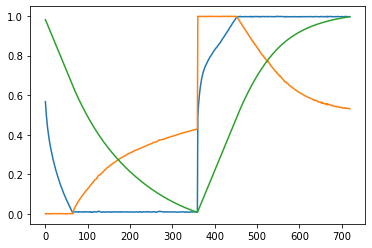

In [25]:
# Use the scaler_3d function from baumhofer_utils.py to scale the data.
# Also convert np.nan values to zeros, if there are np.nan values present in the arrays.
X_train_sc, X_val_sc, X_test_sc = scaler_3d(X_train, X_val, X_test, scaler_type="minmax")

# Visualise the result
plt.plot(X_train_sc[0])
plt.show()

### Now we have train, val and test sets for X and y, ready to be used with models
We can implement k-fold cross validation separately. These fixed sets are just a starting point

In [ ]:
# Save processed data to file
# TODO
# ...